QLIP
====

**QLIP: Text-Aligned Visual Tokenization Unifies Auto-Regressive Multimodal Understanding and Generation**

* Paper: https://arxiv.org/pdf/2502.05178

![QLIP Overview](../assets/qlip_overview.png)


```bash
git clone https://github.com/NVlabs/QLIP.git

pip install torch torchvision
pip install transformers
```

### Load model

In [1]:
import sys
import torch
from transformers import CLIPImageProcessor, CLIPTokenizer
from torchvision.transforms import Normalize
from PIL import Image

sys.path.append("QLIP/QLIP")  # must clone repo
from modeling_qlip import QLIPModel

processor = CLIPImageProcessor.from_pretrained(
    "nvidia/QLIP-B-8-256"
)
tokenizer = CLIPTokenizer.from_pretrained(
    "nvidia/QLIP-B-8-256"
)
model = QLIPModel.from_pretrained(
    "nvidia/QLIP-B-8-256"
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.eval().to(device);

/home/pyml/anaconda3/envs/py311/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of QLIPModel were not initialized from the model checkpoint at nvidia/QLIP-B-8-256 and are newly initialized: ['vision_decoder.encoder.layers.0.self_attn.rope.freqs_cos', 'vision_decoder.encoder.layers.0.self_attn.rope.freqs_sin', 'vision_decoder.encoder.layers.1.self_attn.rope.freqs_cos', 'vision_decoder.encoder.layers.1.self_attn.rope.freqs_sin', 'vision_decoder.encoder.layers.10.self_attn.rope.freqs_cos', 'vision_decoder.encoder.layers.10.self_attn.rope.freqs_sin', 'vision_decoder.encoder.layers.11.self_attn.rope.freqs_cos', 'vision_decoder.encoder.layers.11.self_attn.rope.freqs_sin', 'vision_decoder.encoder.layers.2.self_attn.rope.freqs_cos', 'vision_decoder.encoder.layers.2.self_attn.rope.freqs_sin', 'visio

### Inference example

In [2]:
image_path = "../samples/plants.jpg"
image = Image.open(image_path)
captions = ["a dog", "a cat", "a plant"]

input_ids = tokenizer(
    captions, return_tensors="pt", padding=True
).input_ids.to(device)
input_pixels = processor(
    images=image, return_tensors="pt", padding=True
).pixel_values.to(device)

with torch.no_grad():
    outputs = model(input_ids, input_pixels)

print(f"model outputs: {outputs.keys()}")

Unused or unrecognized kwargs: padding.


model outputs: odict_keys(['logits_per_image', 'logits_per_text', 'text_embeds', 'image_embeds', 'text_model_output', 'vision_model_output', 'reconstructions'])


In [3]:
print("logits per image:", outputs.logits_per_image.cpu().numpy())
print("logits per text:", outputs.logits_per_text.cpu().numpy())

logits per image: [[-1.5476025  -0.23974146 11.993626  ]]
logits per text: [[-1.5476025 ]
 [-0.23974146]
 [11.993626  ]]


In [4]:
with torch.no_grad():
    #image_features = outputs["image_embeds"]
    image_features = model.get_image_features(input_pixels)
    #text_features = outputs["text_embeds"]
    text_features = model.get_text_features(input_ids)
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)

label_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
print(f"model label_probs: {label_probs}")

model label_probs: tensor([[1.3209e-06, 4.8831e-06, 9.9999e-01]], device='cuda:0')


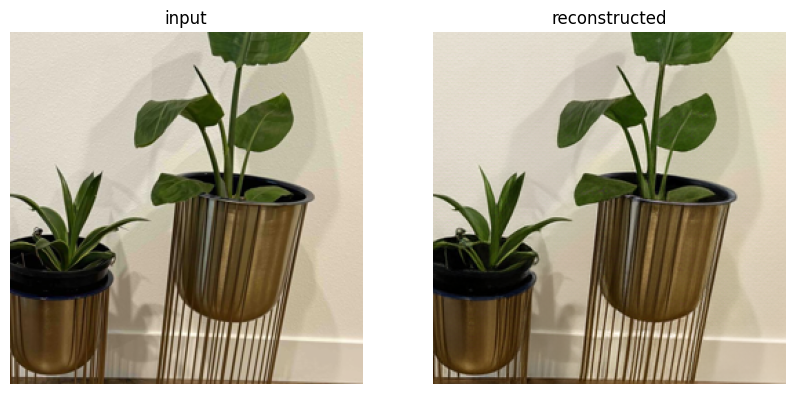

In [5]:
norm_mean = [
    -m / s for m, s in zip(processor.image_mean, processor.image_std)
]
norm_std = [1 / s for s in processor.image_std]
inverse_normalize = Normalize(
    mean=norm_mean,
    std=norm_std
)

input2 = inverse_normalize(input_pixels[0]).clamp_(0, 1)
recon = inverse_normalize(
    outputs["reconstructions"][0]
).clamp_(0, 1)

import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(input2.permute(1, 2, 0).cpu())
axes[0].set_title("input")
axes[0].axis("off")
axes[1].imshow(recon.permute(1, 2, 0).cpu())
axes[1].set_title("reconstructed")
axes[1].axis("off")
plt.show()

## Image-Text matching

In [6]:
import os

texts = [
    "a person", "a house", "a bicycle", "fruits", "a plant"
]

image_paths = [
    f for f in os.listdir("../samples/")
    if f.endswith('.jpg') and not f.startswith('anchor_')
]

imgs = [
    Image.open(os.path.join("../samples/", f)).convert("RGB")
    for f in image_paths
]

input_ids = tokenizer(
    texts, return_tensors="pt", padding=True
).input_ids.to(device)
input_pixels = processor(
    images=imgs, return_tensors="pt", padding=True
).pixel_values.to(device)

Unused or unrecognized kwargs: padding.


In [ ]:
with torch.no_grad():
    image_features = model.get_image_features(input_pixels)
    text_features = model.get_text_features(input_ids)
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)

print("image features shape:", image_features.shape)
print("text features shape:", text_features.shape)

image features shape: torch.Size([8, 512])
text features shape: torch.Size([5, 512])
